# Oklahoma Mesonet Data

This notebook is intended to process Mesonet weather data from 1996-1997, colocated in time and space with Carlson field study. 

- Carlson Data
    - Sent by Derek van der Kamp (DVDK)
    - Includes air temp for all times, where did he get this for old times??
- Oklahoma Mesonet data
    - Slapout station
    - Half-hour sensor data from 1996-1997
    - Weather averaged over the hour except rain, which is accumulated over the period
    - No air temp data, so using from DVDK data, linear interp to half hour resolution

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.utils import read_yml, str2time, time_intp

In [2]:
dweather = pd.read_excel("data/processed_data/dvdk_weather.xlsx")
ok_weather = pd.read_csv("data/OK_Mesonet/Slapout_96-97_weather.csv")
ok_rain = pd.read_csv("data/OK_Mesonet/Slapout_96-97_rain.csv")
nlist = read_yml("etc/nlists/ok_mesonet.yaml")

## Join 

Join rain and weather

**Data Processing**
- Standardize names, lookup tables in etc
- convert -999, -99 to NA
- Units to metric:
    - temp def F to K
    - wind, mpg to m/s
    - rain, in to mm
- Date: CDT to UTC

In [3]:
print(f"Number of weather observations: {ok_weather.shape[0]}")
print(f"Number of rain observations: {ok_rain.shape[0]}")
print()
print(f"Times match: {np.all(ok_weather.TIME == ok_rain.TIME)}")

Number of weather observations: 35088
Number of rain observations: 35088

Times match: True


In [4]:
df = ok_weather.merge(ok_rain, how="left", on=["STID", "TIME"])
df.replace(-999, np.nan, inplace=True)
df.replace(-99, np.nan, inplace=True)

# Rename
df = df.rename(columns=nlist)

# Units
df.temp = (df.temp - 32) * 5/9 + 273.15
df.tmax = (df.tmax - 32) * 5/9 + 273.15
df.tmin = (df.tmin - 32) * 5/9 + 273.15
df.wind = df.wind * 0.44704
df.gust = df.gust * 0.44704
df.rain = df.rain * 25.4

## Handle Times

Steps:
- Confirm time zones
    - All times from OK are CDT
    - Investigation to confirm that data from DVDK switches CST/CDT

NOTE: CDT is UTC-5

In [5]:
df["date"] = pd.to_datetime(df["date"])
print(f"Unique Time Lags 30min: {df.date.diff().unique()}")

Unique Time Lags 30min: <TimedeltaArray>
[NaT, '0 days 00:30:00']
Length: 2, dtype: timedelta64[ns]


Start time from Carlson data: 1996-03-26 15:00:00


Text(0.5, 1.0, 'Solar Radiation')

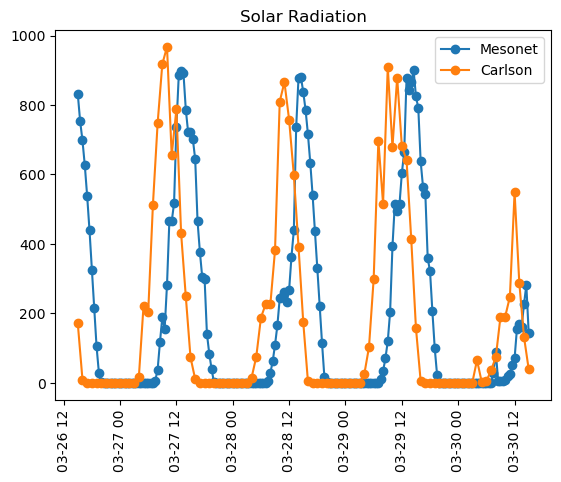

In [6]:
# Check time series of solar radiation to see if they match
# Looks like 1hr time diff in this period
t0 = dweather.date.min()
print(f"Start time from Carlson data: {t0}")
t1 = t0 + pd.Timedelta(hours=96)
x1 = df[(df.date >= t0) & (df.date <= t1)]
x2 = dweather[(dweather.date >= t0) & (dweather.date <= t1)]

plt.plot(x1.date, x1.solar, label="Mesonet", linestyle='-', marker='o')
plt.plot(x2.date, x2.solar, label="Carlson", linestyle='-', marker='o')
plt.xticks(rotation=90);
plt.legend()
plt.title("Solar Radiation")

Starting time of observations is 1996-03-26 15:00:00, which in Oklahoma corresponds to CST. That explains the time mismatch in this period. Below we plot the solar radiation for a period that is CDT to check it is close.

Text(0.5, 1.0, 'Solar Radiation')

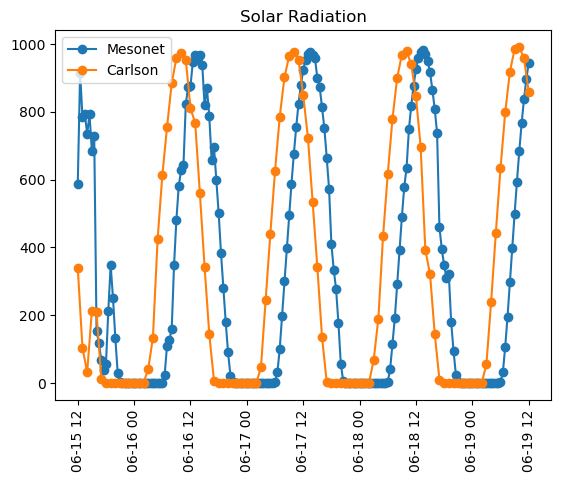

In [7]:
t0 = pd.Timestamp('1996-06-15 12:00:00')
t1 = t0 + pd.Timedelta(hours=96)
x1 = df[(df.date >= t0) & (df.date <= t1)]
x2 = dweather[(dweather.date >= t0) & (dweather.date <= t1)]

plt.plot(x1.date, x1.solar, label="Mesonet", linestyle='-', marker='o')
plt.plot(x2.date, x2.solar, label="Carlson", linestyle='-', marker='o')
plt.xticks(rotation=90);
plt.legend()
plt.title("Solar Radiation")

Still off by 1hr, looks like data from DVDK was all CST. Checking a period in 1997 to be sure.

Text(0.5, 1.0, 'Solar Radiation')

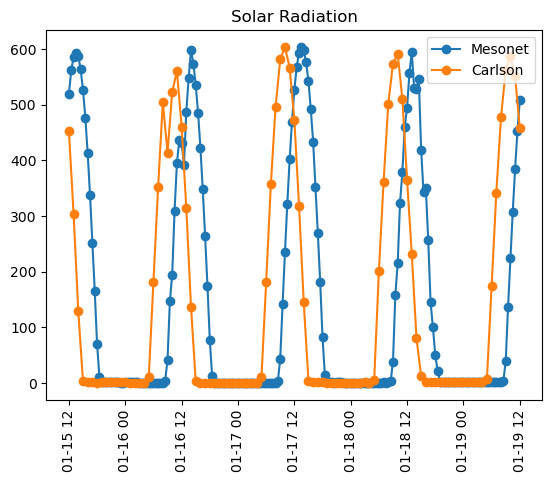

In [8]:
t0 = pd.Timestamp('1997-01-15 12:00:00')
t1 = t0 + pd.Timedelta(hours=96)
x1 = df[(df.date >= t0) & (df.date <= t1)]
x2 = dweather[(dweather.date >= t0) & (dweather.date <= t1)]

plt.plot(x1.date, x1.solar, label="Mesonet", linestyle='-', marker='o')
plt.plot(x2.date, x2.solar, label="Carlson", linestyle='-', marker='o')
plt.xticks(rotation=90);
plt.legend()
plt.title("Solar Radiation")

### Set timezones, adjust to UTC

Setting,
- OK Mesonet: CDT
- Carlson data from DVDK: CST

line up and convert to UTC

In [9]:
# OK CDT
df['date'] = df['date'].dt.tz_localize('Etc/GMT+5')
df['date'] = df['date'].dt.tz_convert('UTC')

In [10]:
# DVDK CST
dweather['date'] = dweather['date'].dt.tz_localize('Etc/GMT+6')
dweather['date'] = dweather['date'].dt.tz_convert('UTC')

Start time from Carlson data: 1996-03-26 21:00:00+00:00


Text(0.5, 1.0, 'Solar Radiation')

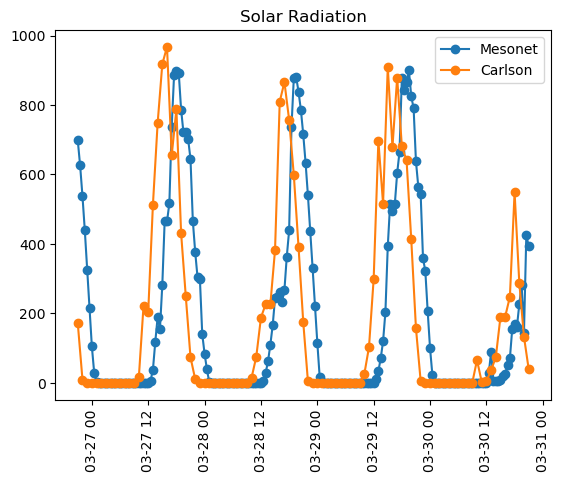

In [11]:
# Check time series of solar radiation again
t0 = dweather.date.min()
print(f"Start time from Carlson data: {t0}")
t1 = t0 + pd.Timedelta(hours=96)
x1 = df[(df.date >= t0) & (df.date <= t1)]
x2 = dweather[(dweather.date >= t0) & (dweather.date <= t1)]

plt.plot(x1.date, x1.solar, label="Mesonet", linestyle='-', marker='o')
plt.plot(x2.date, x2.solar, label="Carlson", linestyle='-', marker='o')
plt.xticks(rotation=90);
plt.legend()
plt.title("Solar Radiation")

Closer than before, still a mismatch. Due to data sources?

Start time from Carlson data: 1996-03-26 21:00:00+00:00


Text(0.5, 1.0, 'Wind')

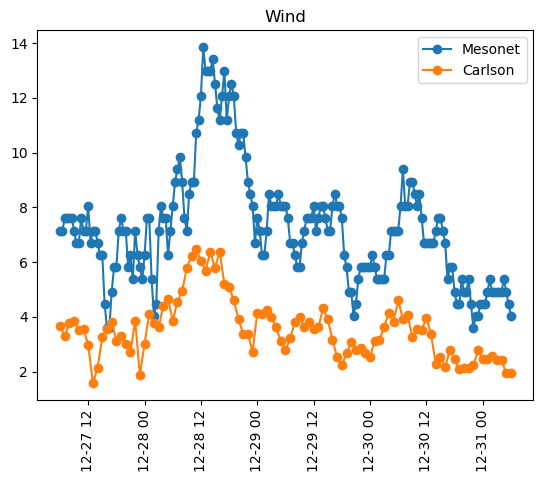

In [12]:
t1 = dweather.date.max()
print(f"Start time from Carlson data: {t0}")
t0 = t1 - pd.Timedelta(hours=96)
x1 = df[(df.date >= t0) & (df.date <= t1)]
x2 = dweather[(dweather.date >= t0) & (dweather.date <= t1)]

plt.plot(x1.date, x1.wind, label="Mesonet", linestyle='-', marker='o')
plt.plot(x2.date, x2.wind, label="Carlson", linestyle='-', marker='o')
plt.xticks(rotation=90);
plt.legend()
plt.title("Wind")

Start time from Carlson data: 1997-12-27 06:00:00+00:00


Text(0.5, 1.0, 'Temp')

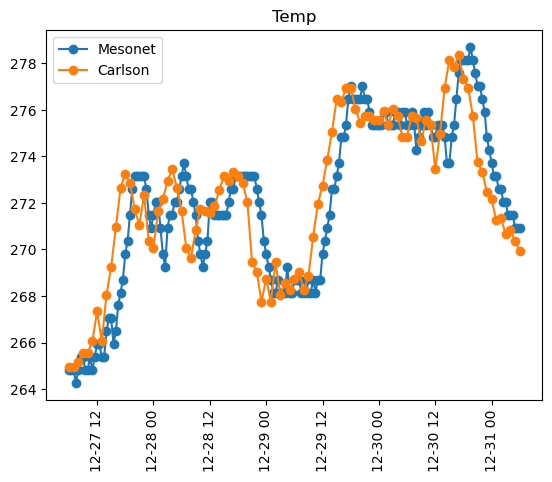

In [13]:
t1 = dweather.date.max()
print(f"Start time from Carlson data: {t0}")
t0 = t1 - pd.Timedelta(hours=96)
x1 = df[(df.date >= t0) & (df.date <= t1)]
x2 = dweather[(dweather.date >= t0) & (dweather.date <= t1)]

plt.plot(x1.date, x1.temp, label="Mesonet", linestyle='-', marker='o')
plt.plot(x2.date, x2.temp, label="Carlson", linestyle='-', marker='o')
plt.xticks(rotation=90);
plt.legend()
plt.title("Temp")

### Temp from 1996 

Air temp not in older Mesonet data, using from DVDK. NOTE: still need to reconcile data mismatches.

Interp temp data to fill in OK Mesonet gaps.

In [14]:
# All missing temps from OK Meso
df2 = df[df.temp.isna()].copy()

# Time of earliest temp record from DVDK data
t0 = dweather.date.min()
# Time of last missing OK Mesonet
t1 = df2.date.max()

# Filter to dates
df2 = df2[(df2.date >= t0) & (df2.date <= t1)]
dw2 = dweather[(dweather.date >= t0) & (dweather.date <= t1)]

In [15]:
print(f"Missing Temps in DVDK Data: {dw2.temp.isna().sum()}")

Missing Temps in DVDK Data: 0


In [16]:
# Linear interp Interp predictions to exact times of FMC
temp2 = time_intp(
    t1 = dw2.date.to_numpy(),
    v1 = dw2.temp,
    t2 = df2.date.to_numpy()
)

In [17]:
df2["temp"] = temp2

In [18]:
# Copy into main df
df.set_index('date', inplace=True)
df.update(df2.set_index('date')[['temp']])  # aligns on index, touches only 'temp'
df.reset_index(inplace=True)

## Interp Missing

Fill in missing observations with linear interpolation so no missing values

NOTE: only fixing missing data during period when temp was filled with DVDK data, which is minimum time from fm. 

Check that missing data is not greater than 3 consecutive hours, interp otherwise

In [37]:
t0 = dweather.date.min()
df2=df[df.date>=t0]
print(f"Total observation times: {df2.shape[0]}")
print(f"Total missing values by variable")
print(f"    Missing date: {df2.date.isna().sum()}")
print(f"    Missing rh: {df2.rh.isna().sum()}")
print(f"    Missing temp: {df2.temp.isna().sum()}")
print(f"    Missing wind: {df2.wind.isna().sum()}")
print(f"    Missing solar: {df2.solar.isna().sum()}")
print(f"    Missing rain: {df2.rain.isna().sum()}")

Total observation times: 30976
Total missing values by variable
    Missing date: 0
    Missing rh: 55
    Missing temp: 0
    Missing wind: 71
    Missing solar: 6
    Missing rain: 17


In [41]:
missing = df.rh.isna()
# get ids of missing to check if consecutive run 
run_id = (missing != missing.shift()).cumsum()

In [47]:
tmp = df2[['date','rh']].copy()
tmp['missing'] = missing
tmp['run_id'] = run_id
tmp[tmp['missing']].head(20)

,date,rh,missing,run_id
9535,1996-07-17 20:30:00+00:00,NaN,True,2
9536,1996-07-17 21:00:00+00:00,NaN,True,2
24026,1997-05-15 18:00:00+00:00,NaN,True,4
24027,1997-05-15 18:30:00+00:00,NaN,True,4
25571,1997-06-16 22:30:00+00:00,NaN,True,6
25572,1997-06-16 23:00:00+00:00,NaN,True,6
25573,1997-06-16 23:30:00+00:00,NaN,True,6
25574,1997-06-17 00:00:00+00:00,NaN,True,6
25575,1997-06-17 00:30:00+00:00,NaN,True,6
25576,1997-06-17 01:00:00+00:00,NaN,True,6


## Calculate Other Features and Save

In [ ]:
df["hod"] = df.date.dt.hour
df["doy"] = df.date.dt.dayofyear

# Geographic features from Slapout
df["elev"] = 774
df["lon"] = -100.261920
df["lat"] = 36.597490

# Equilibria
rh = df.rh
temp = df.temp
Ed = 0.924 * rh**0.679 + 0.000499 * np.exp(0.1 * rh) + 0.18 * (21.1 + 273.15 - temp) * (1 - np.exp(-0.115 * rh))
Ew = 0.618 * rh**0.753 + 0.000454 * np.exp(0.1 * rh) + 0.18 * (21.1 + 273.15 - temp) * (1 - np.exp(-0.115 * rh))

df["Ed"] = Ed
df["Ew"] = Ew

## Save

In [ ]:
df['date'] = df['date'].dt.tz_localize(None)
df.to_excel("data/processed_data/mesonet.xlsx")